In [1]:
from astropy.io import fits
import os, gc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_path, veloce_logs

In [3]:
run = "CSV_Run"
date = '230826'
arm = 'green'
amplifier_mode = 4
filename = '26aug20146.fits'
science_targets = ['HD20203-USQ01']

In [4]:
veloce_paths = veloce_path.VelocePaths(run)
veloce_paths.__post_init__()

In [6]:
master_type = f'flat_{arm}'
# master_flat, hdr = veloce_reduction_tools.get_master_mmap(obs_list,
#                     master_type, veloce_paths.raw_parent_dir, run, date, arm)
master_flat_filename =  f'master_{master_type}_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_flat_filename,
#                                         veloce_paths.master_dir, master_flat, hdr)
        # veloce_extraction.extract_blaze(master_flat_filename, arm=f"{arm}", amp_mode=amplifier_mode)

In [7]:
# veloce_reduction_tools.save_image_fits(master_flat_filename,
#                                         os.path.join(veloce_paths.reduction_parent_dir, 'Master'), master_flat, hdr)
with fits.open(os.path.join(veloce_paths.master_dir, master_flat_filename)) as hdul:
    master_flat = hdul[0].data
    hdr = hdul[0].header

In [8]:
with fits.open(os.path.join(veloce_paths.raw_dir, date, 'ccd_2', filename)) as hdul:
    science = hdul[0].data
    hdr = hdul[0].header

In [9]:
flat_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(master_flat, overscan_range=32, hdr=hdr, amplifier_mode=amplifier_mode)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01


In [10]:
science_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(science, overscan_range=32, hdr=hdr, amplifier_mode=amplifier_mode)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01


In [13]:
# blured = median_filter(flat_subtracted_bias, (15,15))

In [19]:
# plt.imshow(blured, origin='lower', norm='log')

In [20]:
# binarized = veloce_reduction_tools.get_binary_mask(blured, arm=arm, axis='x')

In [21]:
# plt.imshow(~binarized, origin='lower')

In [12]:
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, 'veloce_green_4amp_sim_calib_trace.pkl'))

In [15]:
# this models scattered light and subtracts it
background = veloce_reduction_tools.fit_background(flat_subtracted_bias, traces)
head = f'scattered light corrected\n---\nBackground statistics:\n---'
median_str = f'median = {np.median(background)}'
max_str = f'max = {np.max(background)}'
std_str = f'stdev = {np.std(background)}'
print('\n'.join([head, median_str, max_str, std_str]))
corrected_flat = flat_subtracted_bias - background
corrected_flat[corrected_flat < 0] = 0

scattered light corrected
---
Background statistics:
---
median = 51.71068916976524
max = 311.5596883322187
stdev = 74.43906087590553


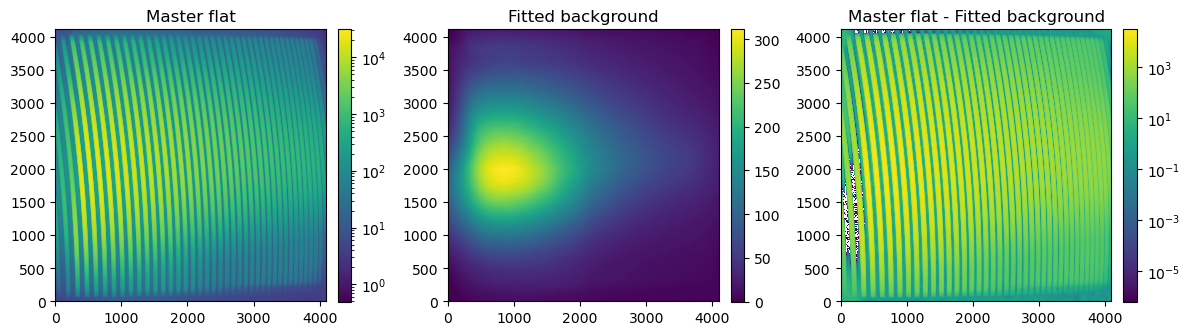

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
im1 = ax1.imshow(flat_subtracted_bias, origin='lower', cmap='viridis', norm='log')
plt.colorbar(im1,ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('Master flat')

im2 = ax2.imshow(background, origin='lower', cmap='viridis')
plt.colorbar(im2,ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title('Fitted background')

im3 = ax3.imshow(corrected_flat, origin='lower', cmap='viridis', norm='log')
plt.colorbar(im3,ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title('Master flat - Fitted background')

# fig.colorbar(ax, ax=fig.get_axes())
plt.tight_layout()
plt.savefig(f'Fitted_background_flat.png')


In [16]:
# this models scattered light and subtracts it
background = veloce_reduction_tools.fit_background(science_subtracted_bias, traces)
head = f'scattered light corrected\n---\nBackground statistics:\n---'
median_str = f'median = {np.median(background)}'
max_str = f'max = {np.max(background)}'
std_str = f'stdev = {np.std(background)}'
print('\n'.join([head, median_str, max_str, std_str]))
corrected_science = science_subtracted_bias - background
corrected_science[corrected_science < 0] = 0

scattered light corrected
---
Background statistics:
---
median = 1.1477122247194265
max = 19.299082261897592
stdev = 1.0582425750467044


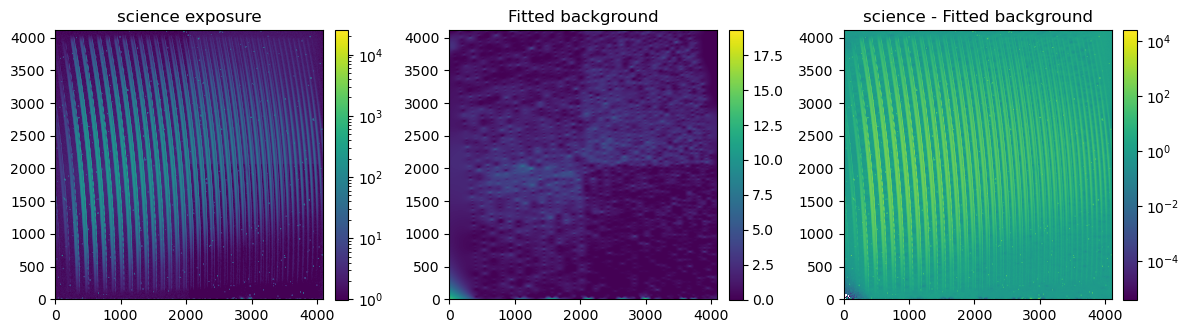

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
im1 = ax1.imshow(science_subtracted_bias, origin='lower', cmap='viridis', norm='log')
plt.colorbar(im1,ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('science exposure')

im2 = ax2.imshow(background, origin='lower', cmap='viridis')
plt.colorbar(im2,ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title('Fitted background')

im3 = ax3.imshow(corrected_science, origin='lower', cmap='viridis', norm='log')
plt.colorbar(im3,ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title('science - Fitted background')

# fig.colorbar(ax, ax=fig.get_axes())
plt.tight_layout()
plt.savefig(f'Fitted_background_science.png')

In [17]:
head = f'scattered light corrected\n---\nBackground statistics:\n---'
median_str = f'median = {np.median(background[500:-500,500:-500])}'
max_str = f'max = {np.max(background[500:-500,500:-500])}'
std_str = f'stdev = {np.std(background[500:-500,500:-500])}'
print('\n'.join([head, median_str, max_str, std_str]))

scattered light corrected
---
Background statistics:
---
median = 1.4862887895633428
max = 8.012294044939127
stdev = 1.0204703563791941


(2480.0, 2520.0)

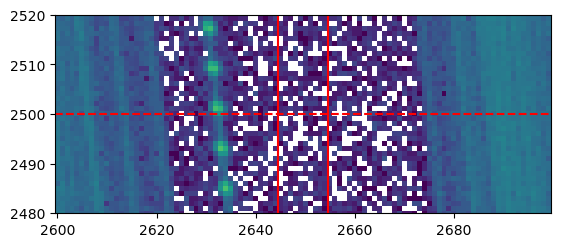

In [15]:
x = (traces.x[20][2500]+traces.x[21][2500])/2
plt.imshow(science_subtracted_bias, origin='lower', cmap='viridis', norm='log')
plt.axvline(x-5, color='red')
plt.axvline(x+5, color='red')
plt.axhline(2500, color='red', linestyle='--')
plt.xlim(x-50, x+50)
plt.ylim(2480, 2520)
